In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as LA

In [2]:
df_train=pd.read_csv('fashionmnist/fashion-mnist_train.csv')
df_test=pd.read_csv('fashionmnist/fashion-mnist_test.csv')

In [3]:
# concat the above dfs and adjust the indices accordingly. They should be from 0 to 69999
df=pd.concat([df_train,df_test],ignore_index=True)

In [4]:
# Identify the columns with string values
string_cols = df.select_dtypes(include=['object']).columns
# Drop the columns with string values
df_numeric = df.drop(string_cols, axis=1)

In [5]:
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
69996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
69997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
69998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
def nearest(pt, Q):
    min_dist_sq = 10**18
    closest_center = 0
    pt = np.array(pt, dtype=np.float64)  # Convert pt to a NumPy array of float64
    for c in Q:
        c = np.array(c, dtype=np.float64)  # Convert c to a NumPy array of float64
        dist_sq = (LA.norm(c - pt))**2
        if dist_sq < min_dist_sq:
            min_dist_sq = dist_sq
            closest_center = c
    return closest_center, min_dist_sq

In [7]:
def kmeans_cost(Q, dataset, wt):
    cost = 0
    dic = {}
    for c in Q:
        dic[tuple(c)] = []
    for p in dataset.values:  # Use the numeric dataset
        c, dp = nearest(p, Q)
        cost += dp
        dic[tuple(c)].append(p)
    return cost, dic

In [30]:
def leverage_sampling(data, red_size):
	print("svd started")
	u, s, v = np.linalg.svd(data.drop('label',axis=1), full_matrices=False)
	print("svd done")
	N = data.shape[0]
	norms = np.zeros(N)
	for j in range(N):
		norms[j]=np.linalg.norm(u[j,:])**2
	norms = norms/norms.sum()
	reduced_set = np.random.choice(N, size=red_size, p=norms)
	return reduced_set

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
coreset_ind = leverage_sampling(df,5000)

svd started
svd done


In [32]:
coreset = df.iloc[coreset_ind]

In [33]:
coreset

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
68025,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33019,8,0,0,0,0,0,0,0,0,0,...,0,0,1,3,17,0,0,0,0,0
14275,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36884,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40433,0,0,0,0,7,133,108,98,113,143,...,0,0,0,4,0,46,139,126,59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63436,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20239,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64601,8,0,1,1,0,158,181,93,125,149,...,0,0,0,0,0,0,0,0,0,0
55558,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

pca = PCA(n_components=2, random_state=42)
data_2d = pca.fit_transform(df.drop('label',axis=1))
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])

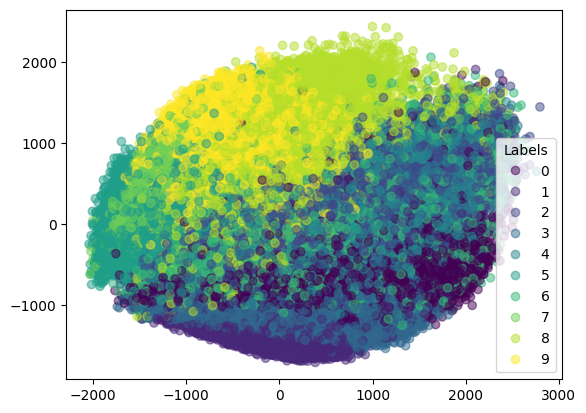

In [22]:
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=df['label'], cmap='viridis', alpha=0.5)
unique_labels = np.unique(coreset['label'])
label_names = label_encoder.inverse_transform(unique_labels)
legend = plt.legend(*scatter.legend_elements(), title='Labels')
legend.texts = [plt.Text(0, 0, name) for name in label_names]
plt.show()

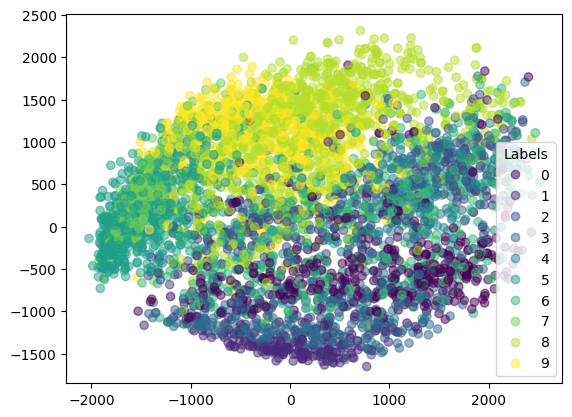

In [35]:
data_2d = pca.transform(coreset.drop('label',axis=1))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=coreset['label'], cmap='viridis', alpha=0.5)
unique_labels = np.unique(coreset['label'])
labels = label_encoder.transform(coreset['label'])
label_names = label_encoder.inverse_transform(unique_labels)
legend = plt.legend(*scatter.legend_elements(), title='Labels')
legend.texts = [plt.Text(0, 0, name) for name in label_names]
plt.show()

In [36]:
from sklearn.metrics import rand_score
rand_score(coreset['label'], kmeans.fit_predict(coreset.drop('label',axis=1)))

0.8621829165833167

In [24]:
rand_score(df['label'], kmeans.fit_predict(df.drop('label',axis=1)))

0.8718339576279661